LSTM BENCHMARK

In [3]:
#Libraries
import pandas as pd
import numpy as np
import re
import unicodedata
import string
import nltk
import spacy
from nltk.corpus import stopwords
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




In [4]:
# Define stopwords for Italian
stop_words_ntlk = set(stopwords.words('italian'))
custom_stopwords = set(["quindi", "pertanto", "dunque", "deve essere", "ogni caso", "devono essere", "esempio", "infatti", "invece", "cioè", "tuttavia", "perché", "solo", "sempre", "così", "riguardo", "ovvero", "però", "comunque", "ancora", 
                        "peraltro", "stesso", "tanto", "poiché", "mentre", "essa", "inoltre", "punto", "quali", "stessa", "proprio", "esso", "perche", "cosi", "cioe", "deve", "essere", "devono", "poiche", "possono", "può", "puo", "poiche", "pero", "senso",
                        "particolare", "oltre", "basta", "secondo", "rispetto", "infine", "soltanto", "detto", "caso", "meno", "ragione", "quando", "basta", "nonche", "volta", "mneo", "ossia", "tale", "tratta",
                        "gia", "pur", "tal","poi","puo","cio"])
stop_words = set(stop_words_ntlk).union(custom_stopwords)

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove legal references (examples: art. 123, d.lgs. 50/2016)
    text = re.sub(r'\b(?:art\.|d\.lgs\.|l\.) \d+(?:/\d+)?', '', text)
    # Remove new lines and tabs
    text = re.sub(r'[\n\t]+', ' ', text)
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove words containing '.' and '_'
    text = ' '.join([word for word in text.split() if '.' not in word and '_' not in word])
    # Remove hyphens and underscores
    text = re.sub(r'[-_]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and non-ASCII characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove very long words (likely errors or concatenated text)
    text = ' '.join([word for word in text.split() if len(word) <= 20])

    return text.strip()

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Load the data
data = pd.read_parquet('SpecialisticMonotopic.parquet', engine='pyarrow')

# Clean the text data
data = data.dropna(subset=['topic', 'text'])
data['topic'] = data['topic'].apply(clean_text)
data['text'] = data['text'].apply(clean_text)
data['text'] = data['text'].apply(remove_stopwords)

# Remove words with less than 4 characters
data['text'] = data['text'].apply(lambda x: re.sub(r'\b\w{1,3}\b', '', x))

data = data.drop_duplicates(subset=['topic', 'text']).reset_index(drop=True)

# Remove texts with less than 10 words
data = data[data['text'].apply(lambda x: len(x.split()) >= 10)]

# Save cleaned data
data.to_csv('SpecialisticMonotopic_cleaned_LSTM.csv', index=False)

print("Data cleaning, stopwords removal completed.")

Data cleaning, stopwords removal completed.


In [5]:
# Load pre-cleaned data
data = pd.read_csv('SpecialisticMonotopic_cleaned_LSTM.csv')

# Check the first few rows of the dataframe
data.head()

,topic,text
0,assicurazione contro i danni,microsoft word cassazione civile cassazione c...
1,assicurazione contro i danni,assicurazioni danni persona assicurazioni dann...
2,assicurazione contro i danni,nozione quadro normativo principio indennitari...
3,responsabilita contrattuale,bisogno avvocato esperto scrivici analizzeremo...
4,responsabilita contrattuale,disciplinata dallarticolo codice civile risarc...


c:\Users\gaiac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\gaiac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\gaiac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


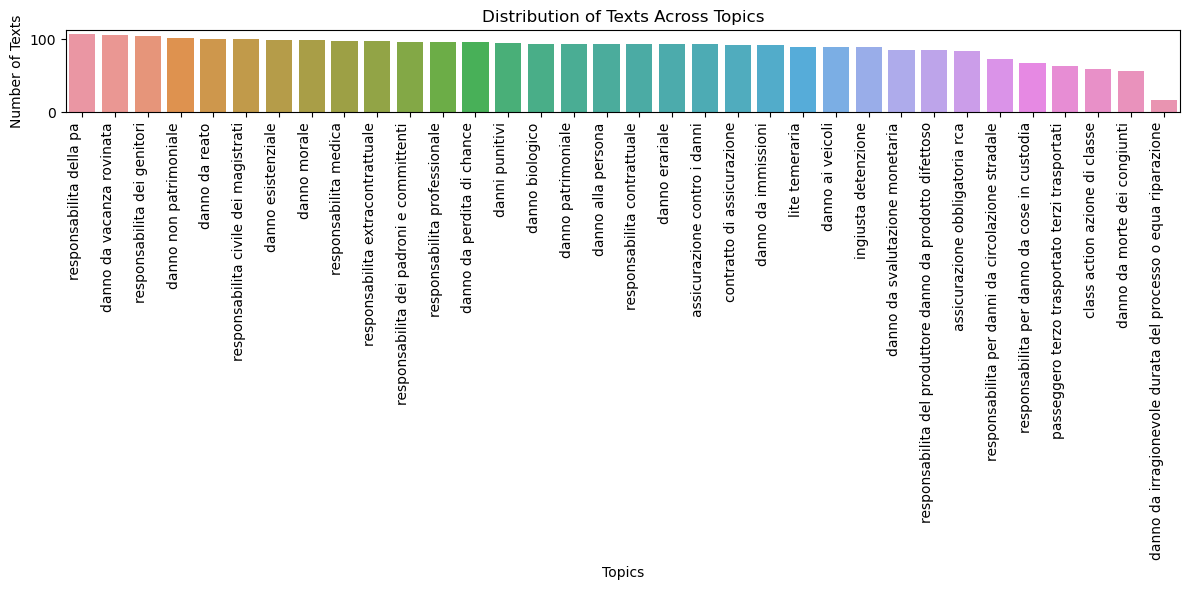

In [6]:
# Topics distribution

# Count the number of texts for each topic
topic_counts = data['topic'].value_counts()

# Replace spaces with underscores in topics
#data['topic'] = data['topic'].str.replace(' ', '_')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Add labels and title
plt.xlabel('Topics')
plt.ylabel('Number of Texts')
plt.title('Distribution of Texts Across Topics')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

Modelling

In [7]:

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Split data into features and labels
texts = data['text'].values
labels = data['topic'].values

# Calculate class weights
unique_labels = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(unique_labels))}

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, categorical_labels, stratify=labels, test_size=0.2, random_state=seed)

# Convert texts to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply TruncatedSVD to reduce dimensions
n_components = 300  # Adjust the number of components as needed
svd = TruncatedSVD(n_components=n_components, random_state=seed)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

# Reshape the data to fit LSTM input requirements
X_train_lstm = X_train_reduced.reshape((X_train_reduced.shape[0], 1, X_train_reduced.shape[1]))
X_test_lstm = X_test_reduced.reshape((X_test_reduced.shape[0], 1, X_test_reduced.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, validation_split=0.2, class_weight=class_weights_dict)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Epoch 1/10


c:\Users\gaiac\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1780 - loss: 3.5353 - val_accuracy: 0.4906 - val_loss: 3.4521
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5422 - loss: 3.4145 - val_accuracy: 0.5156 - val_loss: 3.2477
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5490 - loss: 3.0996 - val_accuracy: 0.5385 - val_loss: 2.7873
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5720 - loss: 2.5362 - val_accuracy: 0.5613 - val_loss: 2.2542
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6198 - loss: 1.9857 - val_accuracy: 0.5821 - val_loss: 1.9046
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6317 - loss: 1.6633 - val_accuracy: 0.5884 - val_loss: 1.7303
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6465 - loss: 1.4511 - val_accuracy: 0.5884 - val_loss: 1.6416
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6531 - loss: 1.3256 - val_accuracy: 0.5884 - val_

Evaluation

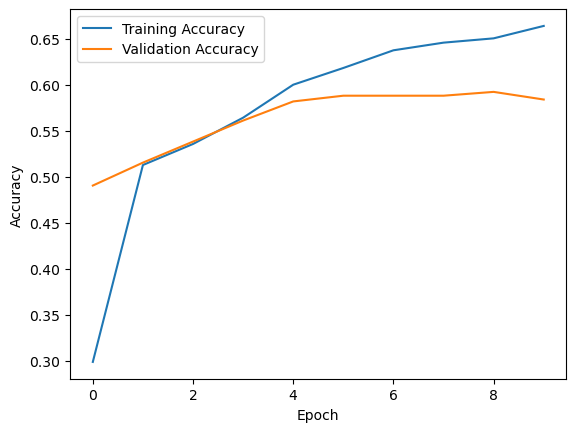

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


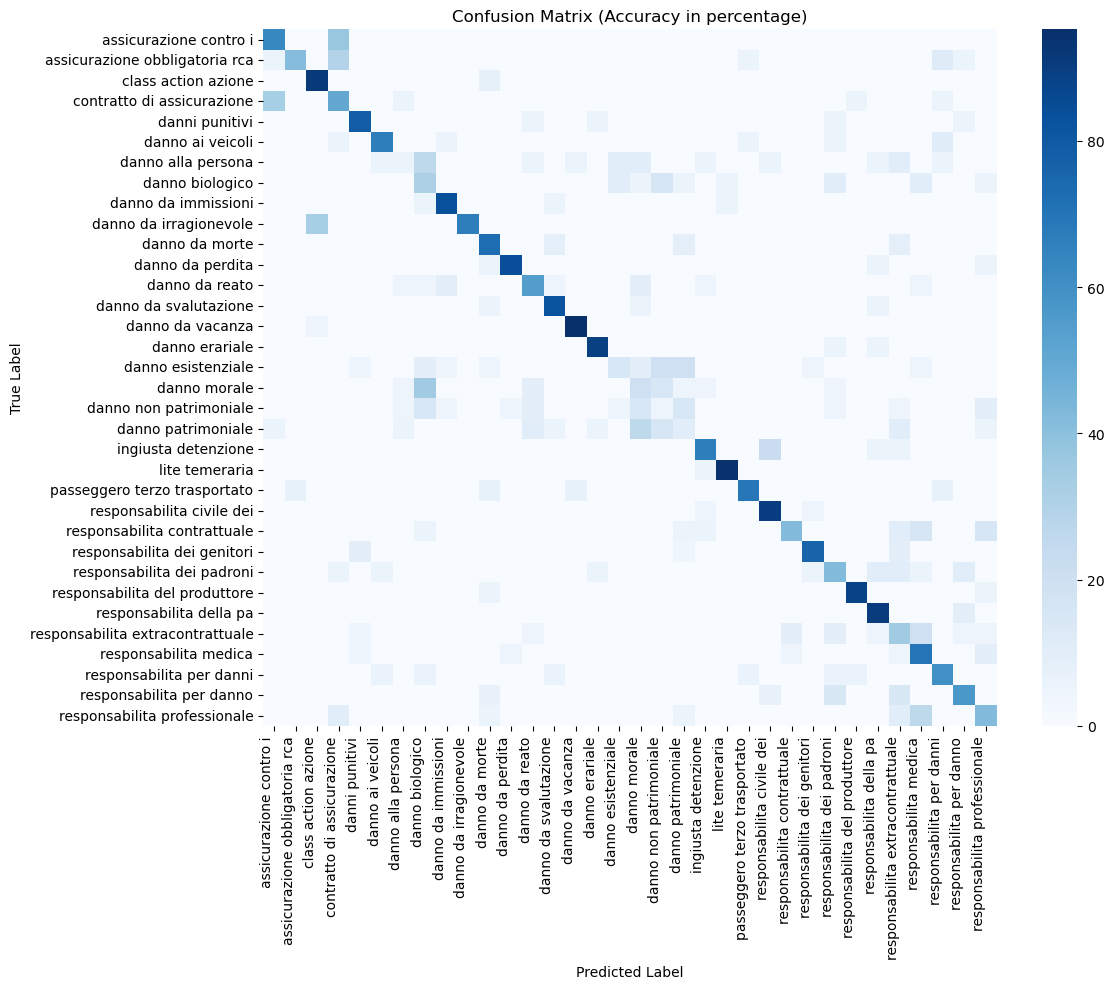

Accuracy: 0.5880


In [8]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Function to truncate class names to a maximum of 3 words
def truncate_class_name(class_name, max_words=3):
    words = class_name.split()
    truncated_name = ' '.join(words[:max_words])
    return truncated_name

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Get class names and truncate them
class_names = label_encoder.classes_
truncated_class_names = [truncate_class_name(name) for name in class_names]

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percentage, annot=False, fmt='d', cmap='Blues', 
            xticklabels=truncated_class_names, yticklabels=truncated_class_names)
plt.title('Confusion Matrix (Accuracy in percentage)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# If you want to see the accuracy score
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")


In [9]:
class_names = label_encoder.classes_

# Print misclassifications with percentages
misclassifications = []
print("\nMisclassifications:")
for i, actual_class in enumerate(labels):
    for j, predicted_class in enumerate(labels):
        if i != j and i < cm.shape[0] and j < cm.shape[1] and cm[i, j] > 0:
            count = cm[i, j]
            percentage = cm_percentage[i, j]
            misclassifications.append((percentage, actual_class, predicted_class, count))
            print(f"Actual: {actual_class}, Predicted: {predicted_class}, Count: {count}, Percentage: {percentage:.2f}%")

# Sort and print the top 5 highest percentages of misclassifications
misclassifications.sort(reverse=True, key=lambda x: x[0])
top_5_misclassifications = misclassifications[:5]

print("\nTop 5 Highest Misclassification Percentages:")
for percentage, actual_class, predicted_class, count in top_5_misclassifications:
    print(f"Actual class '{actual_class}' misclassified as '{predicted_class}': {count} times ({percentage:.2f}%)")



Misclassifications:
Actual: assicurazione contro i danni, Predicted: responsabilita contrattuale, Count: 7, Percentage: 36.84%
Actual: assicurazione contro i danni, Predicted: assicurazione contro i danni, Count: 1, Percentage: 5.88%
Actual: assicurazione contro i danni, Predicted: responsabilita contrattuale, Count: 5, Percentage: 29.41%
Actual: assicurazione contro i danni, Predicted: responsabilita dei genitori, Count: 1, Percentage: 5.88%
Actual: assicurazione contro i danni, Predicted: responsabilita contrattuale, Count: 2, Percentage: 11.76%
Actual: assicurazione contro i danni, Predicted: responsabilita contrattuale, Count: 1, Percentage: 5.88%
Actual: assicurazione contro i danni, Predicted: responsabilita civile dei magistrati, Count: 1, Percentage: 8.33%
Actual: responsabilita contrattuale, Predicted: assicurazione contro i danni, Count: 6, Percentage: 33.33%
Actual: responsabilita contrattuale, Predicted: assicurazione contro i danni, Count: 1, Percentage: 5.56%
Actual: res

In [10]:
# Creating the report

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

#Classification Report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                                                               precision    recall  f1-score   support

                                 assicurazione contro i danni       0.60      0.63      0.62        19
                               assicurazione obbligatoria rca       0.88      0.41      0.56        17
                                class action azione di classe       0.85      0.92      0.88        12
                                   contratto di assicurazione       0.36      0.50      0.42        18
                                               danni punitivi       0.75      0.79      0.77        19
                                             danno ai veicoli       0.80      0.67      0.73        18
                                           danno alla persona       0.17      0.05      0.08        19
                                              danno biologico       0.22      0.32      0.26        19
                                

In [11]:
# Direct replacement of topics with macro topics
data['topic'] = data['topic'].replace({
    'assicurazione contro i danni': 'Assicurazione',
    'assicurazione obbligatoria rca': 'Assicurazione',
    'contratto di assicurazione': 'Assicurazione',
    'class action azione di classe': 'Procedimenti Legali',
    'danno da irragionevole durata del processo o equa riparazione': 'Procedimenti Legali',
    'lite temeraria': 'Procedimenti Legali',
    'danni punitivi': 'Danni Specifici',
    'danno biologico': 'Danni Specifici',
    'danno erariale': 'Danni Specifici',
    'danno esistenziale': 'Danni Specifici',
    'danno da immissioni': 'Danni Specifici',
    'danno morale': 'Danni Specifici',
    'danno da morte dei congiunti': 'Danni Specifici',
    'danno patrimoniale': 'Danni Specifici',
    'danno da perdita di chance': 'Danni Specifici',
    'danno alla persona': 'Danni Specifici',
    'danno da reato': 'Danni Specifici',
    'danno da svalutazione monetaria': 'Danni Specifici',
    'danno da vacanza rovinata': 'Danni Specifici',
    'danno ai veicoli': 'Danni Specifici',
    'danno non patrimoniale': 'Danni Specifici',
    'ingiusta detenzione': 'Violazioni Diritti Personali',
    'passeggero terzo trasportato terzi trasportati': 'Violazioni Diritti Personali',
    'responsabilita contrattuale': 'Responsabilità',
    'responsabilita civile dei magistrati': 'Responsabilità',
    'responsabilita dei genitori': 'Responsabilità',
    'responsabilita extracontrattuale': 'Responsabilità',
    'responsabilita dei padroni e committenti': 'Responsabilità',
    'responsabilita per danni da circolazione stradale': 'Responsabilità',
    'responsabilita professionale': 'Responsabilità',
    'responsabilita medica': 'Responsabilità',
    'responsabilita della pa': 'Responsabilità',
    'responsabilita del produttore danno da prodotto difettoso': 'Responsabilità',
    'responsabilita per danno da cose in custodia': 'Responsabilità'
})

print("Topic replacement completed.")
print(data)

# Distribution of macro topics
print("\nDistribution of macro topics:")
print(data['topic'].value_counts())

# Check for any unchanged topics
print("\nUnchanged topics:")
print(data[~data['topic'].isin(['Assicurazione', 'Procedimenti Legali', 'Danni Specifici', 'Violazioni Diritti Personali', 'Responsabilità'])]['topic'].unique())

Topic replacement completed.
                topic                                               text
0       Assicurazione  microsoft word cassazione civile  cassazione c...
1       Assicurazione  assicurazioni danni persona assicurazioni dann...
2       Assicurazione  nozione quadro normativo principio indennitari...
3      Responsabilità  bisogno avvocato esperto scrivici analizzeremo...
4      Responsabilità  disciplinata dallarticolo codice civile risarc...
...               ...                                                ...
3002   Responsabilità  articoli concorsi abilitazioni editoria profes...
3003   Responsabilità  magistratura indipendente sito necessita brows...
3004   Responsabilità  utilizziamo cookie fornire funzionalita social...
3005  Danni Specifici  responsabilita cose custodia sinistro stradale...
3006  Danni Specifici  cose risarcimento risarcimento ristoro compens...

[3007 rows x 2 columns]

Distribution of macro topics:
topic
Danni Specifici                 1

In [12]:

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Split data into features and labels
texts = data['text'].values
labels = data['topic'].values

# Calculate class weights
unique_labels = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(unique_labels))}

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, categorical_labels, stratify=labels, test_size=0.2, random_state=seed)

# Convert texts to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply TruncatedSVD to reduce dimensions
n_components = 300  # Adjust the number of components as needed
svd = TruncatedSVD(n_components=n_components, random_state=seed)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

# Reshape the data to fit LSTM input requirements
X_train_lstm = X_train_reduced.reshape((X_train_reduced.shape[0], 1, X_train_reduced.shape[1]))
X_test_lstm = X_test_reduced.reshape((X_test_reduced.shape[0], 1, X_test_reduced.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, validation_split=0.2, class_weight=class_weights_dict)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Epoch 1/10


c:\Users\gaiac\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3103 - loss: 1.5640 - val_accuracy: 0.6757 - val_loss: 1.5181
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6829 - loss: 1.3475 - val_accuracy: 0.7484 - val_loss: 1.2430
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7571 - loss: 0.9285 - val_accuracy: 0.7692 - val_loss: 0.9426
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7902 - loss: 0.6356 - val_accuracy: 0.7775 - val_loss: 0.7845
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8072 - loss: 0.5329 - val_accuracy: 0.7796 - val_loss: 0.7118
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8113 - loss: 0.4548 - val_accuracy: 0.7692 - val_loss: 0.7078
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8156 - loss: 0.4273 - val_accuracy: 0.7755 - val_loss: 0.6696
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8050 - loss: 0.4122 - val_accuracy: 0.7692 - val_

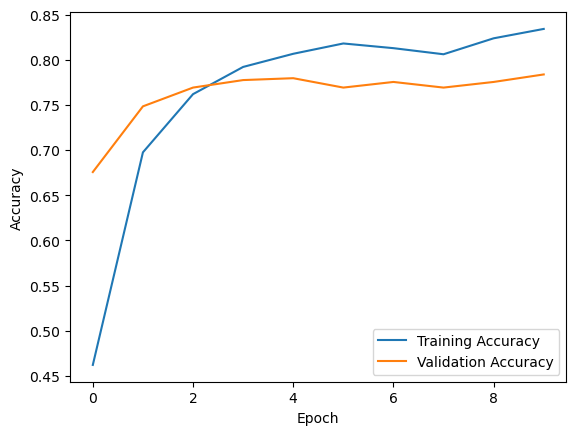

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


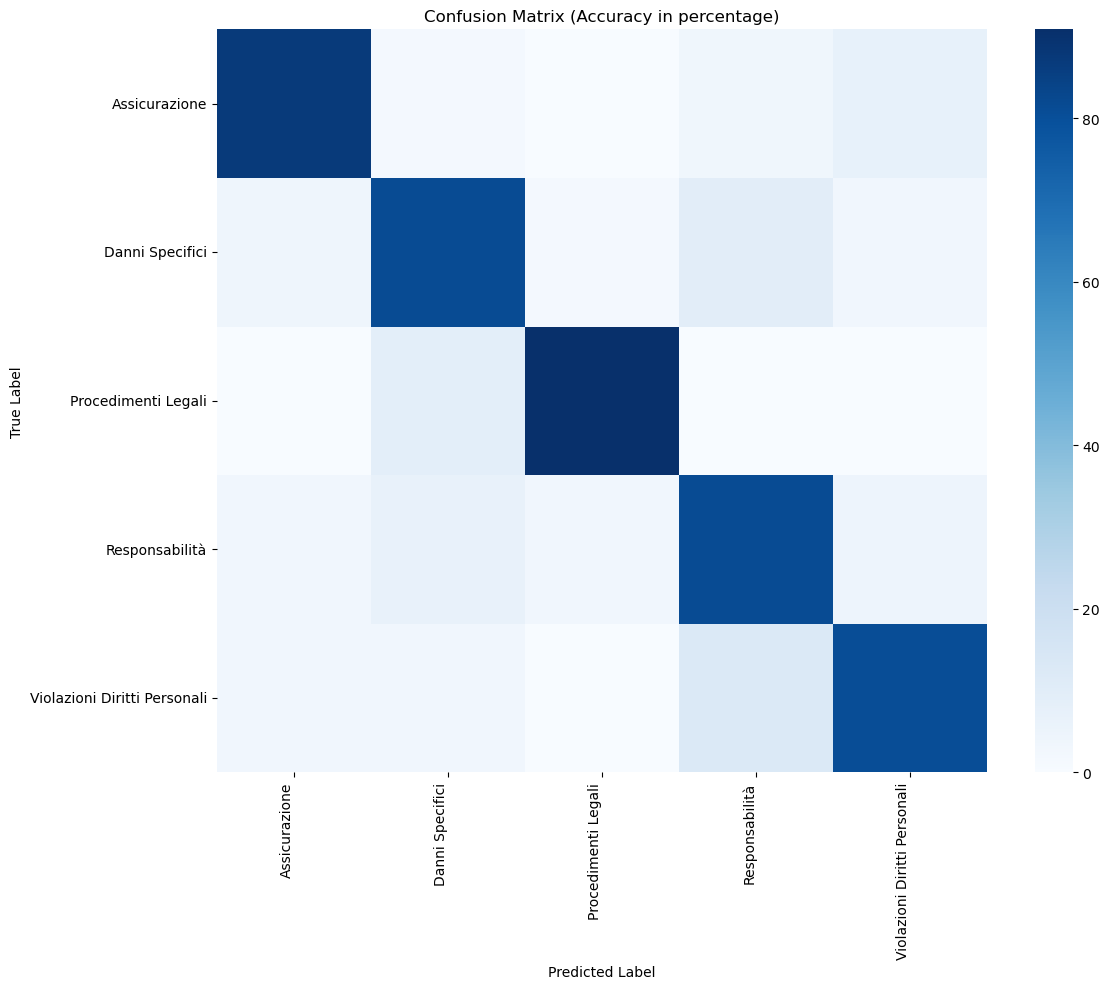

Accuracy: 0.8239


In [13]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Function to truncate class names to a maximum of 3 words
def truncate_class_name(class_name, max_words=3):
    words = class_name.split()
    truncated_name = ' '.join(words[:max_words])
    return truncated_name

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Get class names and truncate them
class_names = label_encoder.classes_
truncated_class_names = [truncate_class_name(name) for name in class_names]

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percentage, annot=False, fmt='d', cmap='Blues', 
            xticklabels=truncated_class_names, yticklabels=truncated_class_names)
plt.title('Confusion Matrix (Accuracy in percentage)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# If you want to see the accuracy score
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")


In [14]:
class_names = label_encoder.classes_

# Print misclassifications with percentages
misclassifications = []
print("\nMisclassifications:")
for i, actual_class in enumerate(labels):
    for j, predicted_class in enumerate(labels):
        if i != j and i < cm.shape[0] and j < cm.shape[1] and cm[i, j] > 0:
            count = cm[i, j]
            percentage = cm_percentage[i, j]
            misclassifications.append((percentage, actual_class, predicted_class, count))
            print(f"Actual: {actual_class}, Predicted: {predicted_class}, Count: {count}, Percentage: {percentage:.2f}%")

# Sort and print the top 5 highest percentages of misclassifications
misclassifications.sort(reverse=True, key=lambda x: x[0])
top_3_misclassifications = misclassifications[:3]

print("\nTop 3 Highest Misclassification Percentages:")
for percentage, actual_class, predicted_class, count in top_3_misclassifications:
    print(f"Actual class '{actual_class}' misclassified as '{predicted_class}': {count} times ({percentage:.2f}%)")



Misclassifications:
Actual: Assicurazione, Predicted: Assicurazione, Count: 1, Percentage: 1.85%
Actual: Assicurazione, Predicted: Responsabilità, Count: 2, Percentage: 3.70%
Actual: Assicurazione, Predicted: Responsabilità, Count: 4, Percentage: 7.41%
Actual: Assicurazione, Predicted: Assicurazione, Count: 11, Percentage: 3.93%
Actual: Assicurazione, Predicted: Assicurazione, Count: 5, Percentage: 1.79%
Actual: Assicurazione, Predicted: Responsabilità, Count: 27, Percentage: 9.64%
Actual: Assicurazione, Predicted: Responsabilità, Count: 9, Percentage: 3.21%
Actual: Assicurazione, Predicted: Assicurazione, Count: 3, Percentage: 9.09%
Actual: Responsabilità, Predicted: Assicurazione, Count: 7, Percentage: 3.43%
Actual: Responsabilità, Predicted: Assicurazione, Count: 14, Percentage: 6.86%
Actual: Responsabilità, Predicted: Assicurazione, Count: 7, Percentage: 3.43%
Actual: Responsabilità, Predicted: Responsabilità, Count: 10, Percentage: 4.90%
Actual: Responsabilità, Predicted: Assicur

In [15]:
# Creating the report

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

#Classification Report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                              precision    recall  f1-score   support

               Assicurazione       0.71      0.87      0.78        54
             Danni Specifici       0.92      0.81      0.87       280
         Procedimenti Legali       0.71      0.91      0.80        33
              Responsabilità       0.83      0.81      0.82       204
Violazioni Diritti Personali       0.52      0.81      0.63        31

                    accuracy                           0.82       602
                   macro avg       0.74      0.84      0.78       602
                weighted avg       0.84      0.82      0.83       602

